# MediaPipe 작업을 사용한 이미지 삽입

이 노트북은 MediaPipe Tasks Python API를 사용하여 두 개의 개별 이미지 파일을 비교하여 얼마나 유사한지 확인하는 방법을 보여줍니다. 이 값의 범위는 -1부터 1까지이며 1은 동일한 이미지입니다. 이는 코사인 유사성이라는 기술을 통해 수행됩니다.

## 준비
프로젝트에 필요한 종속성을 설치하여 시작할 수 있습니다.


In [1]:
!pip install -q mediapipe==0.10.13

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.


다음 단계에서는 이미지 임베딩에 사용할 기성 모델을 다운로드하는 것입니다. 이 경우 mobilenet을 사용하지만 다른 적절한 모델이나 MediaPipe 작업을 통해 고유한 특정 사용 사례에 맞게 구축한 모델을 사용할 수 있습니다.

In [2]:
!wget -O embedder.tflite -q https://storage.googleapis.com/mediapipe-models/image_embedder/mobilenet_v3_small/float32/1/mobilenet_v3_small.tflite

최종 준비 단계에서는 비교할 수 있는 두 개의 별도 이미지가 필요합니다. 다음 코드를 통해 제공된 두 개의 이미지를 다운로드하거나 다른 위치에서 직접 다운로드할 수 있습니다.

In [3]:
import urllib

IMAGE_FILENAMES = ['burger.jpg', 'burger_crop.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-assets/{name}'
  urllib.request.urlretrieve(url, name)

# 이미지 임베딩 수행
비교할 두 이미지를 검색했으므로 이제 표시하여 올바른지 확인할 수 있습니다. 이 예에서는 서로 다르지만 비슷한 두 개의 햄버거 사진이 표시됩니다.

burger.jpg


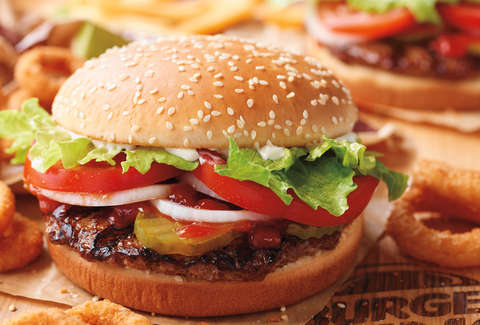

burger_crop.jpg


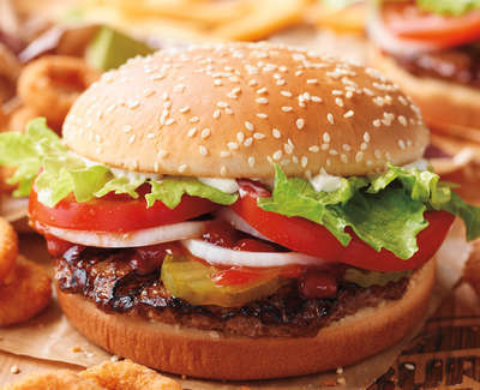

In [4]:
import cv2
from google.colab.patches import cv2_imshow
import math

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)


# Preview the images.
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)
  resize_and_show(image)

모든 것이 좋아지면 추론 수행을 시작할 수 있습니다. 먼저 모델을 Image Embedder와 연결하는 데 필요한 옵션과 일부 사용자 정의를 생성합니다.

다음으로 이미지 임베더를 생성한 다음 코사인 유사성을 사용하여 비교할 수 있도록 MediaPipe에 대한 두 이미지의 형식을 지정합니다.

마지막으로 유사성 값을 표시합니다.

In [5]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Create options for Image Embedder
base_options = python.BaseOptions(model_asset_path='embedder.tflite')
l2_normalize = True #@param {type:"boolean"}
quantize = True #@param {type:"boolean"}
options = vision.ImageEmbedderOptions(
    base_options=base_options, l2_normalize=l2_normalize, quantize=quantize)


# Create Image Embedder
with vision.ImageEmbedder.create_from_options(options) as embedder:

  # Format images for MediaPipe
  first_image = mp.Image.create_from_file(IMAGE_FILENAMES[0])
  second_image = mp.Image.create_from_file(IMAGE_FILENAMES[1])
  first_embedding_result = embedder.embed(first_image)
  second_embedding_result = embedder.embed(second_image)

  # Calculate and print similarity
  similarity = vision.ImageEmbedder.cosine_similarity(
      first_embedding_result.embeddings[0],
      second_embedding_result.embeddings[0])
  print(similarity)

0.9154104779706991


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
